### Import Library

In [1]:
# Pytorch Library
import torch
from torch.autograd import Variable
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# Other Python Library
import matplotlib.pyplot as plt
import numpy as np
import random

torch.manual_seed(777)  # reproducibility

### Loading MNIST dataset

In [2]:
# MNIST dataset
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

Processing...
Done!


torch.Size([60000, 28, 28])
torch.Size([60000])


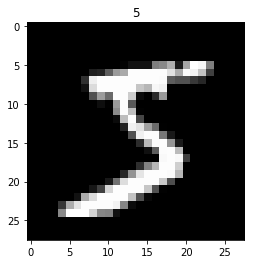

In [3]:
# plot one example
print(mnist_train.train_data.size())                 # (60000, 28, 28)
print(mnist_train.train_labels.size())               # (60000)

idx = 0
plt.imshow(mnist_train.train_data[idx,:,:].numpy(), cmap='gray')
plt.title('%i' % mnist_train.train_labels[idx])
plt.show()

### Data Loader (= 전체 Data를 쪼개서 Batch Size 단위로 불러 오는 역할)

torch.Size([100, 1, 28, 28])
torch.Size([100])


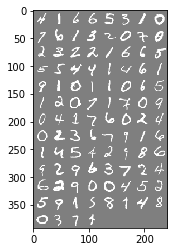

    4     1     6     6     5     3     1     0     7     6     1     3     2     0     7     0     2     3     2     2     1     6     6     5     5     5     4     4     1     4     6     1     9     1     0     1     1     0     6     5     1     2     0     7     1     7     0     9     0     4     1     7     6     0     2     4     0     2     3     6     7     9     1     6     1     4     5     4     2     9     8     6     9     2     9     6     3     7     2     4     6     2     9     0     0     4     5     2     5     9     1     5     8     1     4     8     0     3     7     4


In [4]:
# Hyper-parameters
batch_size = 100

# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True)
#예를 들어서.. 
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# data_loader로 부터 데이터 뭉치를 하나만 불러 오자
dataiter = iter(data_loader)
batch_images, batch_labels = dataiter.next()

print(batch_images.size())
print(batch_labels.size())

# show images and print labels
imshow(utils.make_grid(batch_images))
print(' '.join('%5s' % batch_labels[j] for j in range(batch_size)))

# 실제 사용 예시 for loop를 이용해서 image와 label을 읽어 온다.
# for img,label in data_loader:
#     print(img.size())
#     print(label)
#
#
# enumerate를 사용하는 경우 image와 label을 읽는 것 뿐만 아니라 iter도 같이 계산
# for i, (batch_xs, batch_ys) in enumerate(data_loader):
#     print(img.size())
#     print(label)

### Model을 정의

In [8]:
# 이전 튜토리얼에서는 Softmax Classifer를 구현하기 위해
# Linear 함수와 Softmax함수를 같이 선언한 뒤, Sequential함수로 묶어 모형을 선언 했다.
#
# linear = torch.nn.Linear(4, nb_classes, bias=True)
# softmax = torch.nn.Softmax()                        # softmax = exp(logits) / reduce_sum(exp(logits), dim)
# model = torch.nn.Sequential(linear, softmax)
#

# 그러나 지금 부터는 Score까지만 만들어 주는 Linear만 선언하기로 한다
# # 그 이유는 Pytorch에서 제공해주는 새로운 CrossEntropyLoss 함수를 사용할 것인데
# Cost를 계산하는 과정에 Softmax Layer가 내장 되어 있다.
#
# INPUT: 32 * 32 = 784 차원, OUTPUT: 10 차원 (0~9) 
#
model = torch.nn.Linear(784, 10, bias=True)
model.load_state_dict(torch.load('softmax.pkl'))  # Load the Trained Model

print(model)
print('Weight matrix: ', model.weight.data)
print('bias vector: ', model.bias.data)


Linear (784 -> 10)
Weight matrix:  
 7.4884e-04 -7.5019e-03  5.9947e-04  ...   1.5848e-02  6.9568e-03 -3.2268e-02
 2.6554e-02 -2.0503e-02 -1.7522e-03  ...  -1.7385e-02 -1.6749e-02 -2.7231e-02
 1.2117e-02 -1.0705e-03  1.4638e-02  ...   1.3225e-02 -1.7398e-02  2.4280e-02
                ...                   ⋱                   ...                
-4.8175e-03  7.9931e-03  3.3965e-03  ...   1.8019e-03  1.1178e-02 -2.3904e-02
 1.2171e-02  1.3626e-02  1.7076e-02  ...   8.5097e-03  1.6138e-02 -3.1199e-03
 1.6680e-02  1.1948e-02 -2.2154e-02  ...  -1.1376e-02  1.4803e-02 -3.5909e-03
[torch.FloatTensor of size 10x784]

bias vector:  
-0.6761
 0.8874
 0.1867
-0.5522
 0.2180
 1.7583
-0.2607
 0.9569
-1.8339
-0.4478
[torch.FloatTensor of size 10]



### Cost 함수 정의

In [9]:
# Softmax 함수가 Cost를 계산할 때 내장되어 있다.
cost_func = torch.nn.CrossEntropyLoss()    

### Model 학습

In [10]:
# Hyper-parameters
learning_rate = 0.001 
training_epochs = 5

# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train model
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = len(mnist_train) // batch_size

    for i, (batch_images, batch_labels) in enumerate(data_loader):
        
        # 이미지를 [batch_size x 784] size 행렬로 변환
        
        X = Variable(batch_images.view(-1, 28 * 28))
        Y = Variable(batch_labels)  # label is not one-hot encoded

        
        optimizer.zero_grad()             # Zero Gradient Container
        Y_prediction = model(X)           # Forward Propagation
        cost = cost_func(Y_prediction, Y) # compute cost
        cost.backward()                   # compute gradient
        optimizer.step()                  # gradient update

        avg_cost += cost / total_batch

    print("[Epoch: {:>4}] cost = {:>.9}".format(epoch + 1, avg_cost.data[0]))

print('Learning Finished!')

#torch.save(model.state_dict(), 'softmax.pkl')  # Save the Model

[Epoch:    1] cost = 0.236820832
[Epoch:    2] cost = 0.236107394
[Epoch:    3] cost = 0.235712647
[Epoch:    4] cost = 0.235021934
[Epoch:    5] cost = 0.234710693
[Epoch:    6] cost = 0.234396502
[Epoch:    7] cost = 0.234243855
[Epoch:    8] cost = 0.233351111
[Epoch:    9] cost = 0.233213022
[Epoch:   10] cost = 0.232999295
[Epoch:   11] cost = 0.232776567
[Epoch:   12] cost = 0.232093483
[Epoch:   13] cost = 0.232226834
[Epoch:   14] cost = 0.231427431
[Epoch:   15] cost = 0.231161326
[Epoch:   16] cost = 0.231110007


KeyboardInterrupt: 

### Test Set을 이용한 모형 성능 측정

In [10]:
# Test the Model
correct = 0
total = 0
for images, labels in mnist_test:
    images = Variable(images.view(-1, 28*28))
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += 1
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 92 %


### Random Sample Test

Label:  
 4
[torch.LongTensor of size 1]

Prediction:  
 4
[torch.LongTensor of size 1x1]



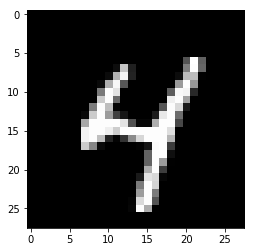

In [22]:
# Get one and predict
r = random.randint(0, len(mnist_test) - 1)
X_single_data = Variable(mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float())
Y_single_data = Variable(mnist_test.test_labels[r:r + 1])

single_prediction = model(X_single_data)

print("Label: ", Y_single_data.data)
print("Prediction: ", torch.max(single_prediction.data, 1)[1])

plt.imshow(X_single_data.data.view(28,28).numpy() , cmap='gray')
plt.show()

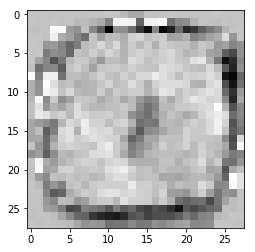

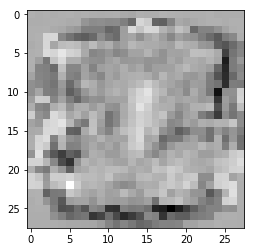

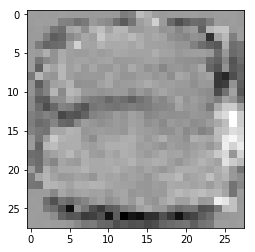

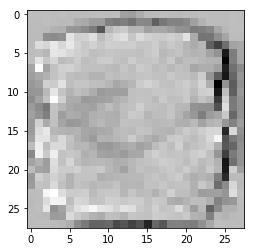

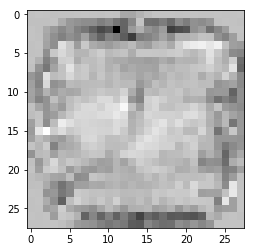

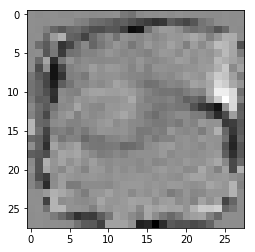

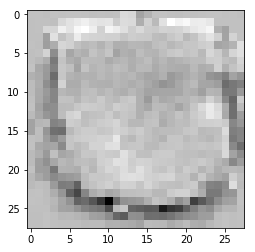

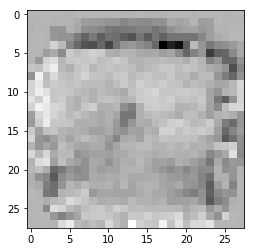

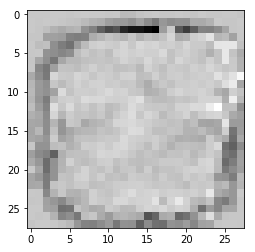

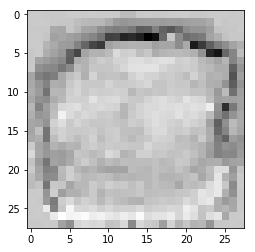

In [23]:
for i in range(10):
    weight = model.weight[i,:].data.view(28,28) 
    #weight = torch.abs(model.weight[i,:].data.view(28,28))
    weight = (weight - torch.min(weight))/(torch.max(weight)-torch.min(weight))
    plt.imshow( weight.numpy(), cmap='gray')
    plt.show()
